In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load



In [2]:
import tensorflow as tf

In [3]:
#Since we're dealing with image files which are big files, GPU will be used for enhanced performance in terms of computations
#Using Kaggle IDE, GPU is integrated & has been activated
#Checking GPU Activation / Listing number of GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


2022-04-09 11:01:46.593685: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-09 11:01:46.685366: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-09 11:01:46.686219: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:

import time
import shutil
import os
os.listdir('/kaggle/input/')

['foodnonfood']

In [5]:
import numpy as np #mathematical fn
import pandas as pd #data manipulation /analysis
import seaborn as sns #statistical data viz
sns.set_style('darkgrid')

import glob #file/path retreival matching pattern
import matplotlib.pyplot as plt #ploting interface

from tensorflow import keras #AI interface for TF Lib
# from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, GlobalAveragePooling2D, MaxPooling2D,BatchNormalization, Flatten #used in DL model layers
from tensorflow.keras.optimizers import Adam, Adamax, RMSprop #to optimize performance

In [6]:
from tqdm import tqdm #tracking bar

#from matplotlib.pyplot import imshow #image in grayscale

from IPython.core.display import display, HTML

from PIL import Image #To represent Python Imaging Lib Image
from sklearn.metrics import confusion_matrix, classification_report #evaluation stage

In [7]:
#NOW let's verify class distribution
# NB: It is important to have a balanced / non-biased dataset  - to prevent model frombeing biased to majority class

train_image_names = glob.glob('../input/foodnonfood/TRAIN/TRAIN/*/*.jpg') #READING OF TRAINIiNG imgs from path
print("Total number of training images: ", len(train_image_names))



Total number of training images:  13113


In [8]:
# make train_image_names as series object
train_image_names = pd.Series(train_image_names)
train_df = pd.DataFrame()

# generate Filename field
train_df['Filename'] = train_image_names.map(lambda img_name: img_name.split("/")[-1])

# generate ClassId field
train_df['ClassId'] = train_image_names.map(lambda img_name: (img_name.split("/")[-2]))
class_id_distribution = train_df['ClassId'].value_counts()
class_id_distribution.head(10)

1    6709
0    6404
Name: ClassId, dtype: int64

In [9]:
from scipy.stats import skew
class_id_distribution.kurt(axis=0)

nan

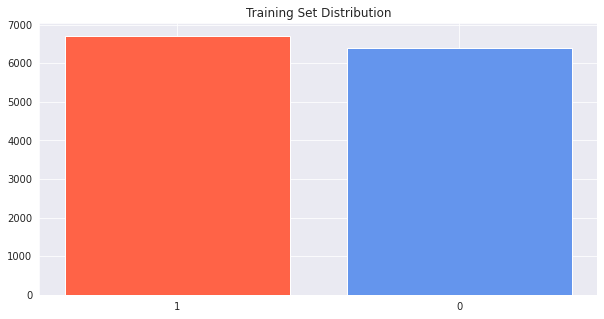

In [10]:
#Now let's visualize the classes in the training; Here we see that the classes are balanced

plt.figure(figsize=(10,5))
plt.bar(class_id_distribution.index, class_id_distribution.values, color=['tomato','cornflowerblue'])
plt.title(label="Training Set Distribution")
plt.show()

In [11]:
#TEST dataset
test = glob.glob('../input/foodnonfood/TEST/TEST/*/*.jpg')
print("Total number of testation images: ", len(test))

# make train_image_names as serie object
test = pd.Series(test)
testdf = pd.DataFrame()

# generate Filename field
testdf['Filename'] = test.map(lambda img_name: img_name.split("/")[-1])

# generate ClassId field
testdf['ClassId'] = test.map(lambda img_name: (img_name.split("/")[-2]))
class_id_distribution = testdf['ClassId'].value_counts()
class_id_distribution.head(10)

Total number of testation images:  3279


1    1678
0    1601
Name: ClassId, dtype: int64

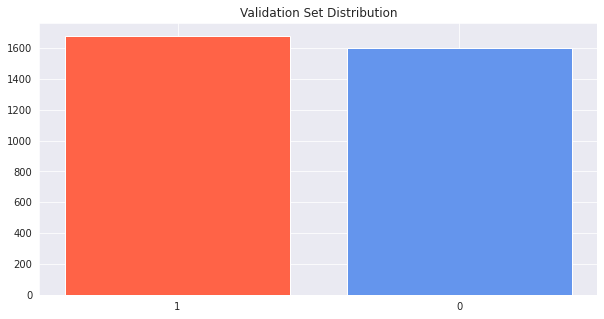

In [12]:
plt.figure(figsize=(10,5))
plt.bar(class_id_distribution.index, class_id_distribution.values, color=['tomato','cornflowerblue'])
plt.title(label="Validation Set Distribution")
plt.show()

In [13]:
from tensorflow import keras #AI interface for TF Lib
# from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, GlobalAveragePooling2D, MaxPooling2D,BatchNormalization, Flatten #used in DL model layers
from tensorflow.keras.optimizers import Adam, Adamax, RMSprop #to optimize performance
from tensorflow.keras.metrics import categorical_crossentropy #Computes the crossentropy metric between the labels and predictions.
from tensorflow.keras import regularizers # Regularizers for applying penalties on layer parameters during optimization.
from tensorflow.keras.preprocessing.image import ImageDataGenerator #For generating image Batches (with augmentation)
from tensorflow.keras.models import Model, load_model, Sequential #seq to group layer stacks linearly into a Model (tf.keras.Model)
from tensorflow.keras.applications import imagenet_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [14]:
#importing pre-trained cnn models
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import plot_model


from tqdm import tqdm #tracking bar

#from matplotlib.pyplot import imshow #image in grayscale

from IPython.core.display import display, HTML

from PIL import Image #To represent Python Imaging Lib Image
from sklearn.metrics import confusion_matrix, classification_report #evaluation stage

In [15]:
#Augmentation using ImageData Generator
train='../input/foodnonfood/TRAIN/TRAIN'
train_datagen = ImageDataGenerator(
        rescale=1./255, #to transform every pixel value from range [0,255] -> [0,1]
        #width_shift_range=0.2, #tried with no improvement
        #height_shift_range=0.2,#tried with no improvement
        shear_range=0.2,#shifting the pixels horizontally
        zoom_range=0.2,
        #rotation_range=20,#tried with no improvement
        horizontal_flip=True,
        fill_mode='nearest')

In [16]:
#reading the training images
training_set = train_datagen.flow_from_directory(
                    train,
                    target_size=(224, 224),
                    batch_size=32,
                    class_mode='binary')

Found 13113 images belonging to 2 classes.


In [23]:
#reading test img
test='../input/foodnonfood/TEST/TEST/'
test_datagen=ImageDataGenerator(rescale=1./255)
testset=test_datagen.flow_from_directory(test,target_size=(224,224),batch_size=32,class_mode='binary')




Found 3279 images belonging to 2 classes.


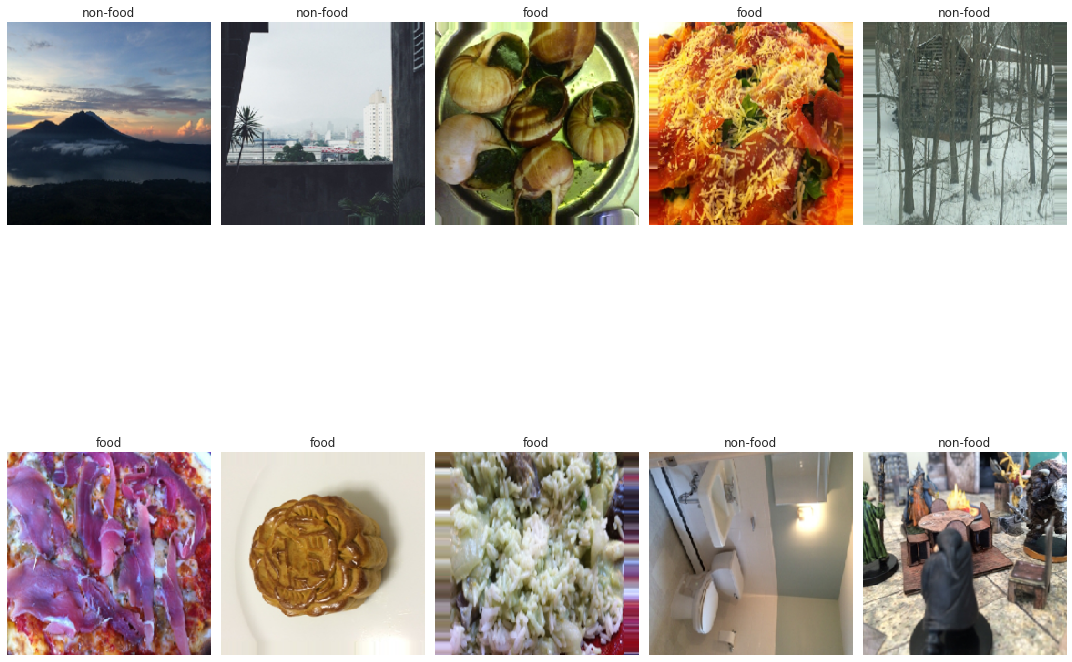

In [55]:
plt.figure(figsize=(15, 15)) #image displayed in size 15X15
for i in range(0, 10):
    plt.subplot(2, 5, i+1) #2 rows with 5 images per row
    for X_batch, Y_batch in training_set:
        image = X_batch[0]        
        dic = {1:'food', 0:'non-food'} 
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),interpolation='nearest') # nearest will display an image without trying to interpolate between pixels since output display resolution != image resolution
        break
plt.tight_layout()
plt.show()

Build model


In [24]:
import os
import time
import tensorflow as tf
import glob
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf
from tensorflow import keras
import os
import tempfile
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.optimizers import SGD, Adam, Adamax
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np # linear algebra
import pandas as pd 
import matplotlib.pyplot as plt #PLOTTING PERF  
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator #used during image prep
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, MaxPooling2D #layers to be used in the CNN arch
from keras.models import Sequential
from tensorflow.keras.utils import plot_model
from keras.layers import Dropout
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import accuracy_score #used for evaluation Metrics
from sklearn.utils.class_weight import compute_class_weight

In [26]:
testset.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [27]:
#shape of the sets
print("training set shape is",training_set[-1])
print("test set shape is",testset[-1])

training set shape is (array([], shape=(0, 224, 224, 3), dtype=float32), array([], dtype=float32))
test set shape is (array([], shape=(0, 224, 224, 3), dtype=float32), array([], dtype=float32))


In [28]:
#verifying current image shapes
print("training images shape is",training_set.image_shape)
print("tes images shape is",testset.image_shape)

training images shape is (224, 224, 3)
tes images shape is (224, 224, 3)


In [34]:
Adapted= Sequential()
Adapted.add(tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=[224,224,3]))
Adapted.add(MaxPool2D(pool_size=2,strides=2))
Adapted.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
Adapted.add(MaxPool2D(pool_size=2,strides=2))
Adapted.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
Adapted.add(MaxPool2D(pool_size=2,strides=2))
Adapted.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu'))
Adapted.add(MaxPool2D(pool_size=2,strides=2))
Adapted.add(Dropout(0.2))
Adapted.add(Flatten())
Adapted.add(Dropout(0.2))
Adapted.add(Dense(units=512,activation='relu'))
Adapted.add(Dense(units=128,activation='relu'))
Adapted.add(Dense(units=64,activation='relu'))
Adapted.add(Dense(units=1,activation='sigmoid')) #only one output required


In [35]:
#additional Metrics
METS = [
      
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]
#compiling model
#binary crossentropy used since this is binary classification model; output has only two classes
Adapted.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',METS])
Adapted.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 256)      

In [36]:
History = Adapted.fit(training_set,
                      validation_data=(testset),
                      epochs=5,
                      callbacks=[EarlyStopping(monitor='val_accuracy',patience=20)]) 
#Using early stopping so that if the validation accuracy does not increase 20X conscutively
#model is then stopped; i.e not all 50 epochs will be completed

Epoch 1/5
410/410 [==============================] - 256s 620ms/step - loss: 0.4017 - accuracy: 0.8198 - precision: 0.8097 - recall: 0.8468 - auc: 0.9006 - val_loss: 0.2489 - val_accuracy: 0.9021 - val_precision: 0.8784 - val_recall: 0.9386 - val_auc: 0.9648
Epoch 2/5
410/410 [==============================] - 168s 411ms/step - loss: 0.2611 - accuracy: 0.8919 - precision: 0.8942 - recall: 0.8945 - auc: 0.9586 - val_loss: 0.2104 - val_accuracy: 0.9195 - val_precision: 0.9101 - val_recall: 0.9350 - val_auc: 0.9728
Epoch 3/5
410/410 [==============================] - 167s 408ms/step - loss: 0.2361 - accuracy: 0.9044 - precision: 0.9107 - recall: 0.9016 - auc: 0.9660 - val_loss: 0.2093 - val_accuracy: 0.9189 - val_precision: 0.9401 - val_recall: 0.8987 - val_auc: 0.9765
Epoch 4/5
410/410 [==============================] - 168s 411ms/step - loss: 0.2073 - accuracy: 0.9181 - precision: 0.9202 - recall: 0.9197 - auc: 0.9737 - val_loss: 0.3472 - val_accuracy: 0.8789 - val_precision: 0.9501 - v

In [37]:
#*others used to catch other output being returned
#evaluation of trained model onto the test set
loss, acc, prec, recall, auc, *others = Adapted.evaluate(testset) 
acc

103/103 [==============================] - 10s 101ms/step - loss: 0.2131 - accuracy: 0.9143 - precision: 0.9446 - recall: 0.8844 - auc: 0.9765


0.9143031239509583

In [38]:
testset.reset()
x=np.concatenate([testset.next()[0] for i in range(testset.__len__())])
y=np.concatenate([testset.next()[1] for i in range(testset.__len__())])
print(x.shape)
print(y.shape)

(3279, 224, 224, 3)
(3279,)


In [39]:
y

array([0., 1., 0., ..., 1., 0., 1.], dtype=float32)

In [40]:
preds = Adapted.predict(testset,verbose=1)

103/103 [==============================] - 10s 99ms/step


In [42]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

In [43]:
predictions

array([[0.],
       [1.],
       [0.],
       ...,
       [1.],
       [0.],
       [1.]], dtype=float32)

In [45]:
print(classification_report(y_true=y,y_pred=predictions,target_names =['NONFOOD','FOOD']))

              precision    recall  f1-score   support

     NONFOOD       0.89      0.95      0.92      1601
        FOOD       0.94      0.88      0.91      1678

    accuracy                           0.91      3279
   macro avg       0.92      0.92      0.91      3279
weighted avg       0.92      0.91      0.91      3279



<AxesSubplot:>

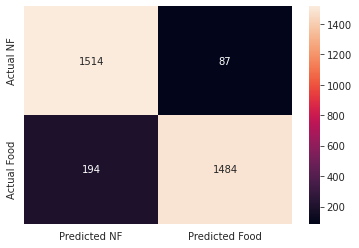

In [46]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(y, predictions, labels=[0, 1]),index=["Actual NF", "Actual Food"],
columns=["Predicted NF", "Predicted Food"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [66]:
predictions

array([[0.],
       [1.],
       [0.],
       ...,
       [1.],
       [0.],
       [1.]], dtype=float32)

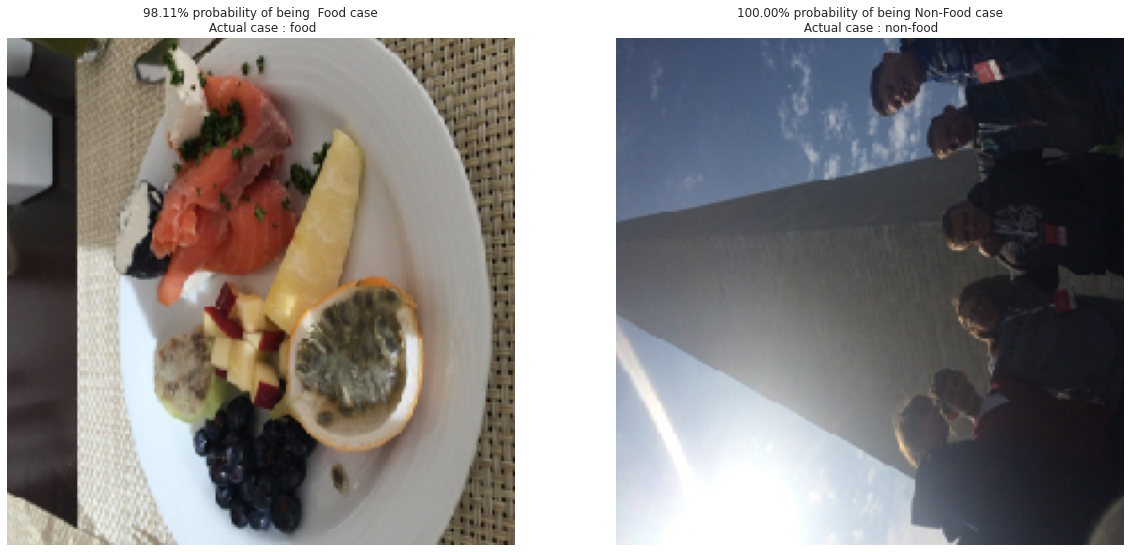

In [76]:

plt.figure(figsize=(20,20))
for i in range(0+46,2+46):
  plt.subplot(1, 2, (i-46)+1)
  if preds[i, 0] >= 0.5: 
      out = ('{:.2%} probability of being  Food case'.format(preds[i][0]))
      
      
  else: 
      out = ('{:.2%} probability of being Non-Food case'.format(1-preds[i][0]))
      
      

  plt.title(out+"\n Actual case : "+ dic.get(y[i]))    
  plt.imshow(np.squeeze(x[i]))
  plt.axis('off')
plt.show()

In [78]:
Adapted.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 256)      

In [106]:
last_layer='conv2d_8'

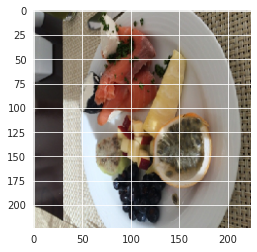

In [97]:
plt.imshow(x[46])

In [100]:
x.shape

(3279, 224, 224, 3)

In [101]:
x[46].shape

(224, 224, 3)

In [103]:
x[-1]

array([[[0.28235295, 0.2392157 , 0.29411766],
        [0.2509804 , 0.20392159, 0.24313727],
        [0.25882354, 0.20784315, 0.24705884],
        ...,
        [0.14901961, 0.18431373, 0.20392159],
        [0.16470589, 0.18431373, 0.20000002],
        [0.22352943, 0.22352943, 0.25490198]],

       [[0.29411766, 0.25490198, 0.2901961 ],
        [0.27058825, 0.22352943, 0.2627451 ],
        [0.27450982, 0.22352943, 0.2627451 ],
        ...,
        [0.12156864, 0.16078432, 0.16862746],
        [0.13333334, 0.16470589, 0.1764706 ],
        [0.16862746, 0.18039216, 0.21568629]],

       [[0.3137255 , 0.2784314 , 0.29803923],
        [0.2784314 , 0.23529413, 0.26666668],
        [0.32941177, 0.2784314 , 0.3137255 ],
        ...,
        [0.1137255 , 0.15294118, 0.15686275],
        [0.11764707, 0.15686275, 0.16470589],
        [0.15686275, 0.17254902, 0.20784315]],

       ...,

       [[0.1764706 , 0.14117648, 0.15294118],
        [0.25490198, 0.21960786, 0.23137257],
        [0.38431376, 0

In [77]:
from tensorflow.keras.models import Model
import cv2


def GradCam(model, imarr, layer_name, eps=1e-8): #epsil value def
    

    gMod = Model(
			inputs=[model.inputs],
			outputs=[model.get_layer(layer_name).output,
				model.output])
    
    with tf.GradientTape() as tape:
      inputs = tf.cast(imarr, tf.float32)
      (convOutputs, predictions) = gMod(inputs)
      loss = predictions[:, 0]
    gradientss = tape.gradient(loss, convOutputs)
    
    csCNVOut = tf.cast(convOutputs > 0, "float32")
    csgradie = tf.cast(gradientss > 0, "float32")
    guidedgradientss = csCNVOut * csgradie * gradientss
    convOutputs = convOutputs[0]
    guidedgradientss = guidedgradientss[0]
    wgts = tf.reduce_mean(guidedgradientss, axis=(0, 1))
    gdcam = tf.reduce_sum(tf.multiply(wgts, convOutputs), axis=-1)
    (w, h) = (imarr.shape[2], imarr.shape[1])
    hm = cv2.resize(gdcam.numpy(), (w, h))
    numer = hm - np.min(hm)
    denom = (hm.max() - hm.min()) + eps
    hm = numer / denom
    return hm


def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def supimp(img_bgr, gdcam, thresh, emphasize=False):
    hm = cv2.resize(gdcam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        hm = sigmoid(hm, 50, thresh, 1)
    hm = np.uint8(255 * hm)
    hm = cv2.applyColorMap(hm, cv2.COLORMAP_JET)
    
    hif = .8
    supimpd_img = hm * hif + img_bgr
    supimpd_img = np.minimum(supimpd_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    supimpd_img_rgb = cv2.cvtColor(supimpd_img, cv2.COLOR_BGR2RGB)
    
    return supimpd_img_rgb

In [110]:
img=x[46]

In [111]:
img = cv2.resize(img,(224,224))     # resize image to match model's expected sizing
img = np.reshape(img,[1,224,224,3]) 

In [112]:
img.shape

(1, 224, 224, 3)

In [117]:
grad_cam=GradCam(Adapted,img,last_layer)

In [140]:
grad_cam_supimpd = supimp(x[46], grad_cam, 0.5, emphasize=True)

In [141]:
grad_cam_supimpd

array([[[  0,   0, 103],
        [  0,   0, 103],
        [  0,   0, 103],
        ...,
        [  0,   0, 102],
        [  0,   0, 102],
        [  0,   0, 102]],

       [[  0,   0, 103],
        [  0,   0, 103],
        [  0,   0, 103],
        ...,
        [  0,   0, 102],
        [  0,   0, 102],
        [  0,   0, 102]],

       [[  0,   0, 102],
        [  0,   0, 102],
        [  0,   0, 102],
        ...,
        [  0,   0, 102],
        [  0,   0, 102],
        [  0,   0, 102]],

       ...,

       [[  0,   0, 119],
        [  0,   0, 119],
        [  0,   0, 119],
        ...,
        [  0,   0, 102],
        [  0,   0, 102],
        [  0,   0, 102]],

       [[  0,   0, 119],
        [  0,   0, 119],
        [  0,   0, 119],
        ...,
        [  0,   0, 102],
        [  0,   0, 102],
        [  0,   0, 102]],

       [[  0,   0, 119],
        [  0,   0, 119],
        [  0,   0, 119],
        ...,
        [  0,   0, 102],
        [  0,   0, 102],
        [  0,   0, 102]]

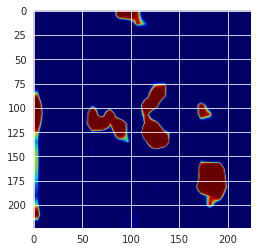

In [144]:
plt.imshow(grad_cam_supimpd)



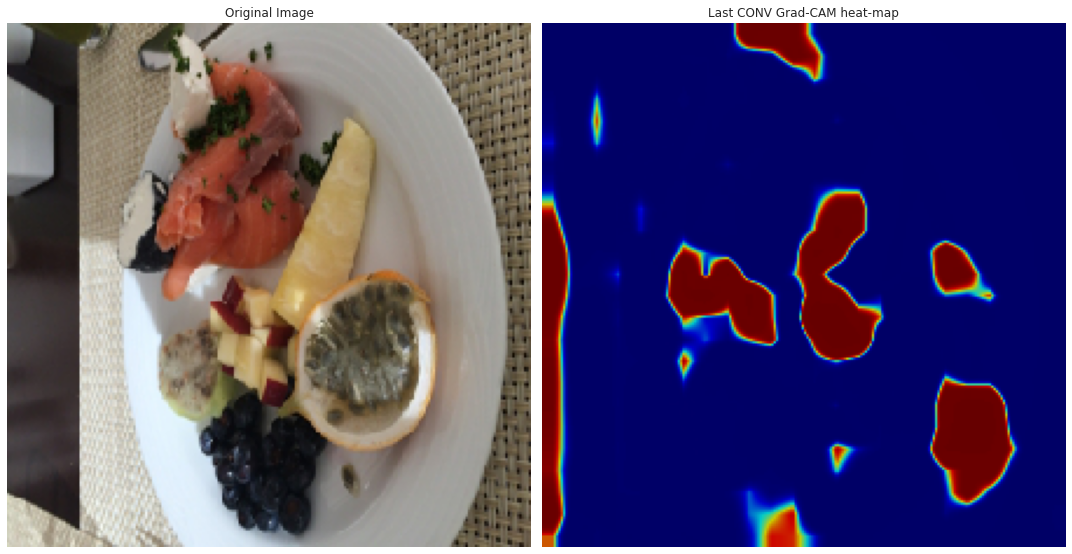

In [139]:
plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 2, 1)
plt.imshow(x[46])
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_supimpd)
plt.axis('off')
plt.title('Last CONV Grad-CAM heat-map')
plt.tight_layout()

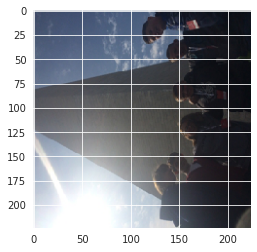

In [149]:
plt.imshow(x[47])

In [145]:
img2=x[47]

In [148]:
img2 = cv2.resize(img2,(224,224))     # resize image to match model's expected sizing
img2 = np.reshape(img2,[1,224,224,3]) 

In [150]:
grad_cam2=GradCam(Adapted,img2,last_layer)

In [153]:
grad_cam_supimpd2 = supimp(x[47], grad_cam2, 0.5, emphasize=True)

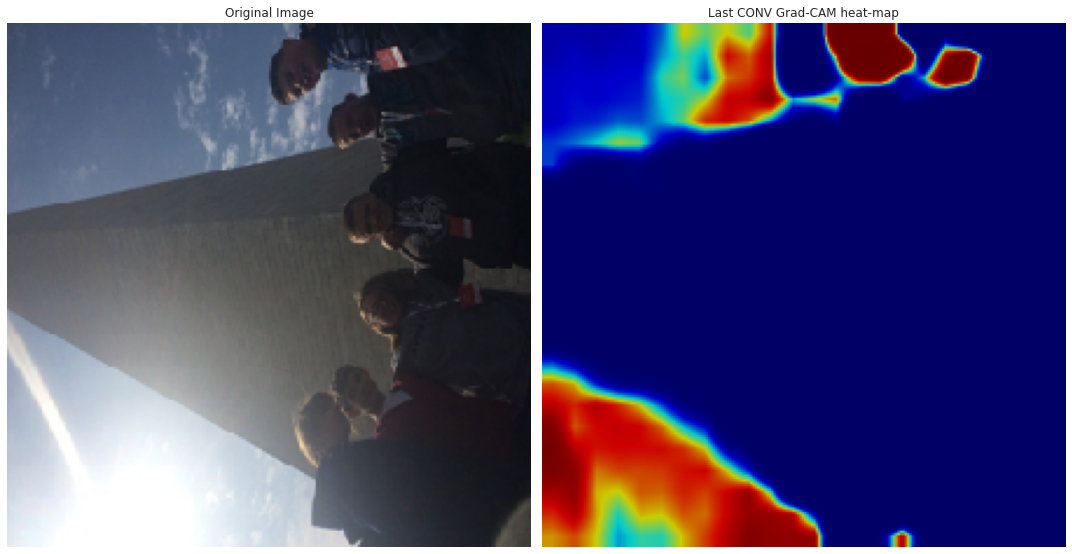

In [154]:
plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 2, 1)
plt.imshow(x[47])
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_supimpd2)
plt.axis('off')
plt.title('Last CONV Grad-CAM heat-map')
plt.tight_layout()